In [1552]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

In [1553]:
def load_adc_data(filename):
    adc1 = []
    adc2 = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    val1 = int(parts[0])
                    val2 = int(parts[1])
                    adc1.append(val1)
                    adc2.append(val2)
                except ValueError:
                    continue  # skip malformed lines
    return adc1, adc2

def plot_time(plotting_list, label=["Plot 1", "Plot 2", "Plot 3", "Plot 4", "Plot 5"], title="ADC Data Plot", y_label="Normalized ADC Value"):
    # Plotting
    marker_list = ['o', 'x', 's', '^', 'D']
    colors = ['b', 'r', 'g', 'c', 'm']
    plt.figure(figsize=(12, 6))
    for i, data in enumerate(plotting_list):
        plt.plot(data, label=label[i], marker=marker_list[i], color=colors[i], linestyle='-', markersize=1)
    # plt.plot(x_values, voltage_value, marker='x', linestyle='-', markersize=2, color='red')
    # plt.title("ADC Data Plot")
    plt.xlabel("Sample Number")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [1554]:
def MA_filter(data, window_size):
    """Apply a moving average filter to the data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [1555]:
def hysterisis(data, middle_threshold, deviation):
    """Apply a moving average filter to the data."""
    lower_threshold = middle_threshold - deviation
    upper_threshold = middle_threshold + deviation
    hysterisis_data = []
    current_state = "LOW" if data[0] < middle_threshold else "HIGH"
    hysterisis_data.append(0 if current_state == "LOW" else 1)
    for value in data:
        if current_state == "LOW":
            if value > upper_threshold:
                hysterisis_data.append(1)
                current_state = "HIGH"
            else:
                hysterisis_data.append(0)
        else:  # current_state == "HIGH"
            if value < lower_threshold:
                hysterisis_data.append(0)
                current_state = "LOW"
            else:
                hysterisis_data.append(1)
    return hysterisis_data

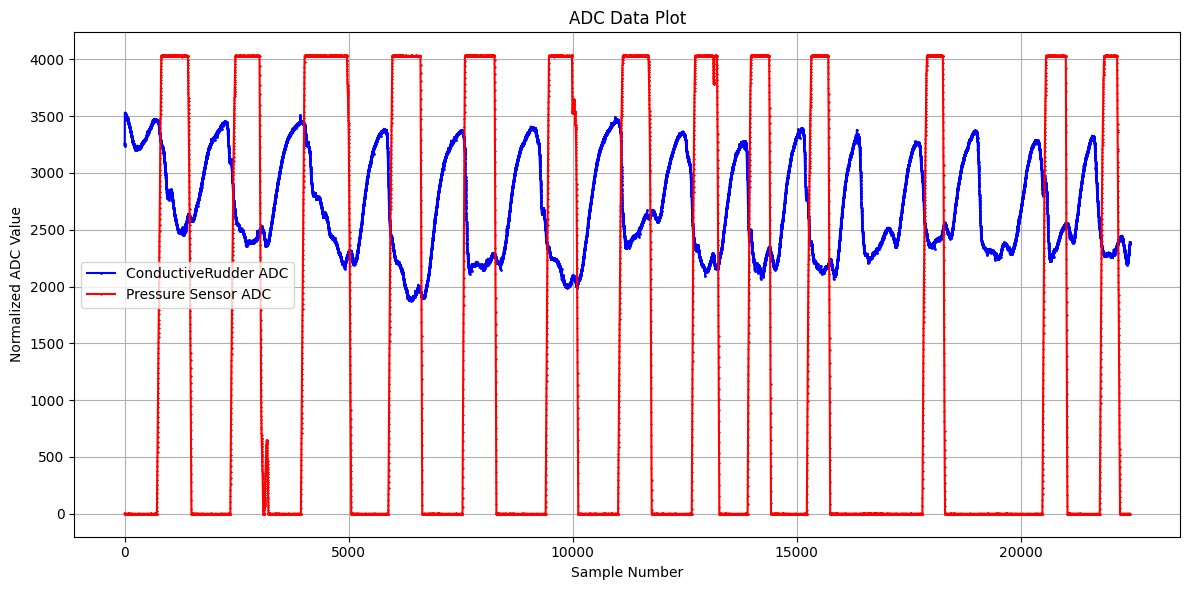

In [1556]:
normal_path = './data/normal/3/adc_normal3_6.data'
sport_path = './data/sport/10/adc_sport10_2.data'
demo_path = "./eval.data"
c_rubber_data, pressure_data = load_adc_data(sport_path)
plot_time([c_rubber_data, pressure_data], label=["ConductiveRudder ADC", "Pressure Sensor ADC"])

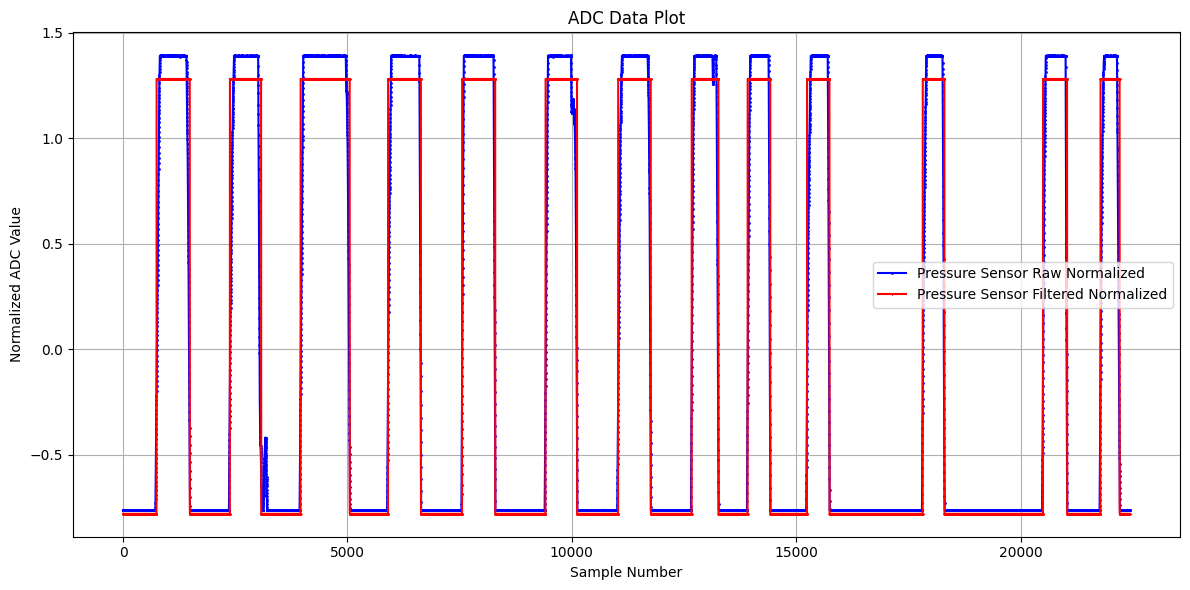

In [1557]:
p_raw_normalized = (pressure_data - np.mean(pressure_data)) / np.std(pressure_data)
p_filtered = hysterisis(pressure_data, 700, 300)
# print("Filtered Pressure Data:", p_filtered)
# normalize the filtered data
p_filtered_normalized = (p_filtered - np.mean(p_filtered)) / np.std(p_filtered)
plot_time([p_raw_normalized, p_filtered_normalized], label=["Pressure Sensor Raw Normalized", "Pressure Sensor Filtered Normalized"])

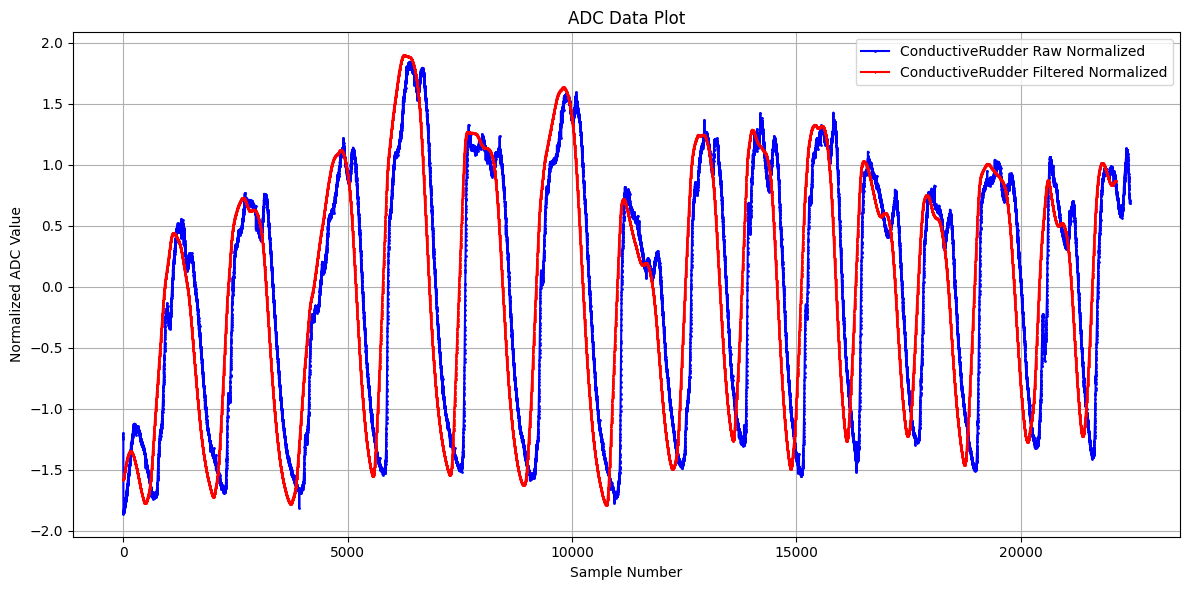

In [1558]:
c_raw_normalized = (c_rubber_data - np.mean(c_rubber_data)) / np.std(c_rubber_data)
c_raw_normalized = -c_raw_normalized
c_filtered = MA_filter(c_rubber_data, 300)
c_filtered_normalized = (c_filtered - np.mean(c_filtered)) / np.std(c_filtered)
c_filtered_normalized = -c_filtered_normalized  # Invert the filtered data
plot_time([c_raw_normalized, c_filtered_normalized], label=["ConductiveRudder Raw Normalized", "ConductiveRudder Filtered Normalized"])

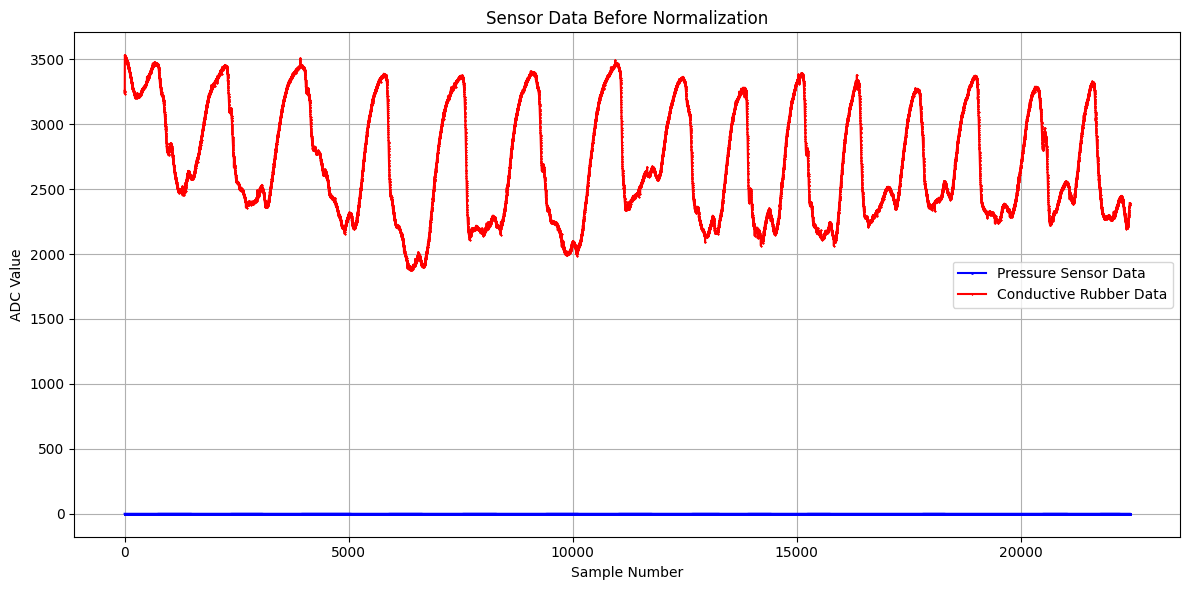

In [1559]:
# sensor_data before normalization
p_before_normalization = p_filtered
c_before_normalization = c_rubber_data
plot_time([p_before_normalization, c_before_normalization], label=["Pressure Sensor Data", "Conductive Rubber Data"], title="Sensor Data Before Normalization", y_label="ADC Value")

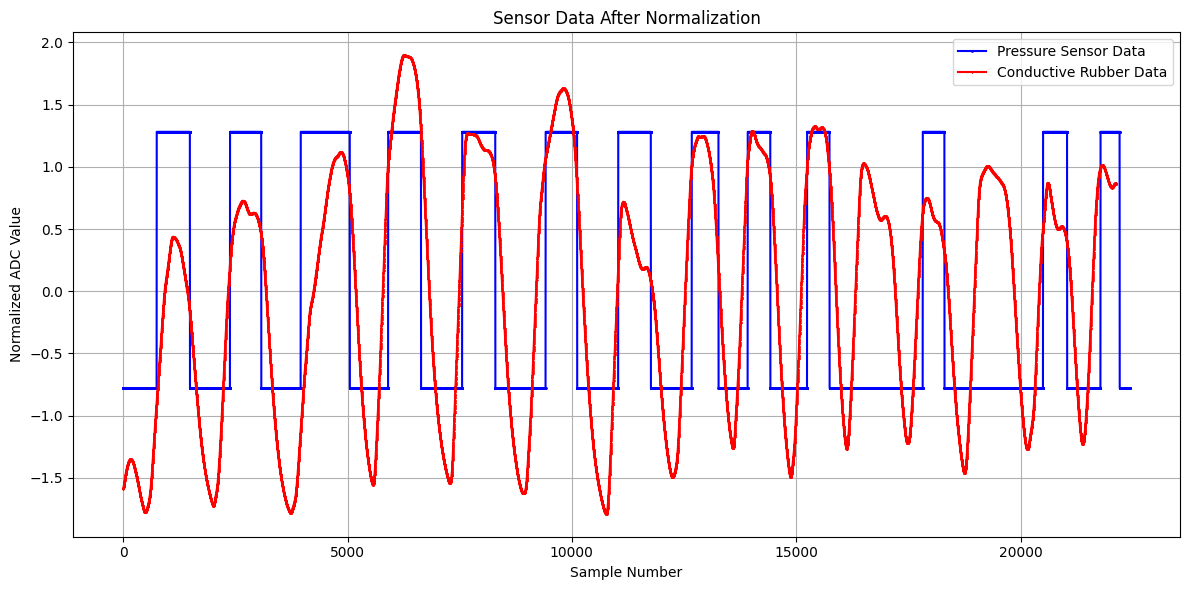

In [1560]:
# sensor data after normalization 
plot_time([p_filtered_normalized, c_filtered_normalized], label=["Pressure Sensor Data", "Conductive Rubber Data"], title="Sensor Data After Normalization")

In [1561]:
peaks_belly_p, props_p = find_peaks(p_filtered_normalized, prominence=0.2, distance=900, plateau_size=1)
peak_p = [int((l + r) / 2) for l, r in zip(props_p["left_edges"], props_p["right_edges"])]
peaks_belly_c, props_c = find_peaks(c_filtered_normalized, prominence=0.2, distance=900, plateau_size=1)
peak_c = [int((l + r) / 2) for l, r in zip(props_c["left_edges"], props_c["right_edges"])]

In [1562]:
print("Peak Pressure Sensor:", peak_p)
print("Peak Conductive Rubber:", peak_c)

Peak Pressure Sensor: [1115, 2727, 4502, 6270, 7923, 9765, 11395, 12969, 14170, 15492, 18061, 20769, 21995]
Peak Conductive Rubber: [164, 1116, 2672, 4846, 6256, 7675, 9808, 11151, 12922, 14023, 15416, 16501, 17910, 19267, 20609]


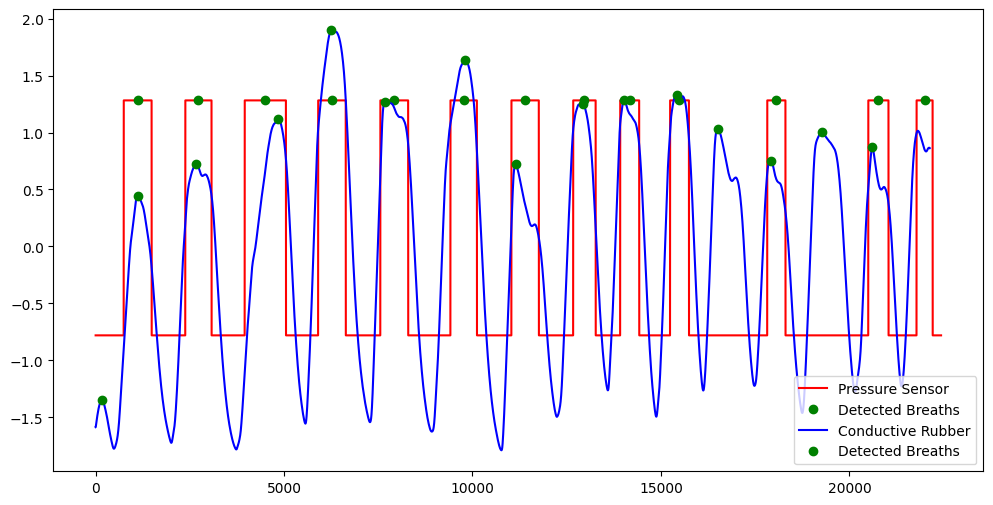

In [1563]:
plt.figure(figsize=(12, 6))
plt.plot(p_filtered_normalized, label='Pressure Sensor', color='red')
plt.plot(peak_p, p_filtered_normalized[peak_p], 'go', label='Detected Breaths')
plt.plot(c_filtered_normalized, label='Conductive Rubber', color='blue')
plt.plot(peak_c, c_filtered_normalized[peak_c], 'go', label='Detected Breaths')
plt.legend()

In [1564]:
# sort the distances between two peaks
sorted_distances_p = sorted(np.diff(peak_p))
sorted_distances_c = sorted(np.diff(peak_c))
print("Sorted peak distance for Pressure Sensor:", sorted_distances_p)
print("Sorted peak distance for Conductive Rubber:", sorted_distances_c)
# find the median of the distances 
median_distance_p = np.median(sorted_distances_p)
median_distance_c = np.median(sorted_distances_c)
print("Median peak distance for P Sensor:", median_distance_p)
print("Median peak distance for C Rubber:", median_distance_c)
# find the 25th and 75th percentile of the distances
percentile_25_p = np.percentile(sorted_distances_p, 25)
percentile_75_p = np.percentile(sorted_distances_p, 75)
percentile_25_c = np.percentile(sorted_distances_c, 25)
percentile_75_c = np.percentile(sorted_distances_c, 75)
# find the interquartile range (IQR)
iqr_peak_p = percentile_75_p - percentile_25_p
iqr_peak_c = percentile_75_c - percentile_25_c
print("IQR distance between peaks P Sensor:", iqr_peak_p)
print("IQR distance between peaks C Rubber:", iqr_peak_c)
print("Len Peak P: ", len(peak_p))
print("Len Peak C: ", len(peak_c))

Sorted peak distance for Pressure Sensor: [np.int64(1201), np.int64(1226), np.int64(1322), np.int64(1574), np.int64(1612), np.int64(1630), np.int64(1653), np.int64(1768), np.int64(1775), np.int64(1842), np.int64(2569), np.int64(2708)]
Sorted peak distance for Conductive Rubber: [np.int64(952), np.int64(1085), np.int64(1101), np.int64(1342), np.int64(1343), np.int64(1357), np.int64(1393), np.int64(1409), np.int64(1410), np.int64(1419), np.int64(1556), np.int64(1771), np.int64(2133), np.int64(2174)]
Median peak distance for P Sensor: 1641.5
Median peak distance for C Rubber: 1401.0
IQR distance between peaks P Sensor: 280.75
IQR distance between peaks C Rubber: 179.5
Len Peak P:  13
Len Peak C:  15


In [1565]:
def find_match_from_adc1(peaks_c, cur_peak_p, acceptable_dist):
    for i in range(len(peaks_c)):
        # print("plateau_mids1[i] - cur_adc2_peak: ", plateau_mids1[i] - cur_adc2_peak)
        if abs(peaks_c[i] - cur_peak_p) < acceptable_dist: 
            return peaks_c[i]
    return None
    

In [1566]:
def detect_abnormal(data, gap):
    if not data:
        return []
    result = [data[0]]
    for prev, curr in zip(data, data[1:]):
        if abs(curr - prev) > gap:
            result.append("abnormal")
        result.append(curr)
    return result

In [1567]:
def remove_close_peaks(peaks, min_distance):
    if not peaks:
        return []
    filtered_peaks = [peaks[0]]
    for peak in peaks[1:]:
        if peak - filtered_peaks[-1] >= min_distance:
            filtered_peaks.append(peak)
    return filtered_peaks

In [1568]:
# use adc2 for base decision making and adc1 for aiding decision making
print("Peak Index Pressure Sensor", peak_p)
print("Distance between peaks: ", np.diff(peak_p))
print("Close peak distance:" , median_distance_p * 0.6)
peak_p = remove_close_peaks(peak_p, median_distance_p * 0.6)
print("Peak index after removing close peaks:", peak_p)
median_tolerance = iqr_peak_p 
acceptable_peak_distance = (median_distance_p + median_tolerance)*1.15
print("Acceptable distance:", acceptable_peak_distance)   
peak_p_abnormal = detect_abnormal(peak_p, acceptable_peak_distance)
print("Final Peak Index:", peak_p_abnormal)
print("Total Cycle", len(peak_p_abnormal))

Peak Index Pressure Sensor [1115, 2727, 4502, 6270, 7923, 9765, 11395, 12969, 14170, 15492, 18061, 20769, 21995]
Distance between peaks:  [1612 1775 1768 1653 1842 1630 1574 1201 1322 2569 2708 1226]
Close peak distance: 984.9
Peak index after removing close peaks: [1115, 2727, 4502, 6270, 7923, 9765, 11395, 12969, 14170, 15492, 18061, 20769, 21995]
Acceptable distance: 2210.5874999999996
Final Peak Index: [1115, 2727, 4502, 6270, 7923, 9765, 11395, 12969, 14170, 15492, 'abnormal', 18061, 'abnormal', 20769, 21995]
Total Cycle 15


In [1569]:
def abnormal_replacement(peak_p_abnormal, peaks_c, median_distance_p, iqr_peak_p):
    result = []
    for i in range(len(peak_p_abnormal)):
        if peak_p_abnormal[i] == "abnormal":
            try:
                front = peak_p_abnormal[i-1]
                back = peak_p_abnormal[i+1]
                middle = (front + back)/2
                match = find_match_from_adc1(peaks_c, middle, acceptable_dist=2*iqr_peak_p)
                if match is not None:
                    print("Match found for abnormal peak at index", i, ":", match)
                    result.append(match)
                else:
                    print("No match found for abnormal peak at index", i)
                    result.append(round(middle))
            except IndexError:
                result.append(peak_p_abnormal[i-1] + median_distance_p)  # Keep the abnormal value if no neighbors are available
        else:
            result.append(peak_p_abnormal[i])    
    return result

In [1570]:
final_peak_index = abnormal_replacement(peak_p_abnormal, peak_c, median_distance_p, iqr_peak_p)
print("Final Peak Num: ", len(final_peak_index))
print("Final Peak Index:", final_peak_index)
print("Peak p", peak_p)

Match found for abnormal peak at index 10 : 16501
Match found for abnormal peak at index 12 : 19267
Final Peak Num:  15
Final Peak Index: [1115, 2727, 4502, 6270, 7923, 9765, 11395, 12969, 14170, 15492, 16501, 18061, 19267, 20769, 21995]
Peak p [1115, 2727, 4502, 6270, 7923, 9765, 11395, 12969, 14170, 15492, 18061, 20769, 21995]


Text(0, 0.5, 'Normalized ADC Value')

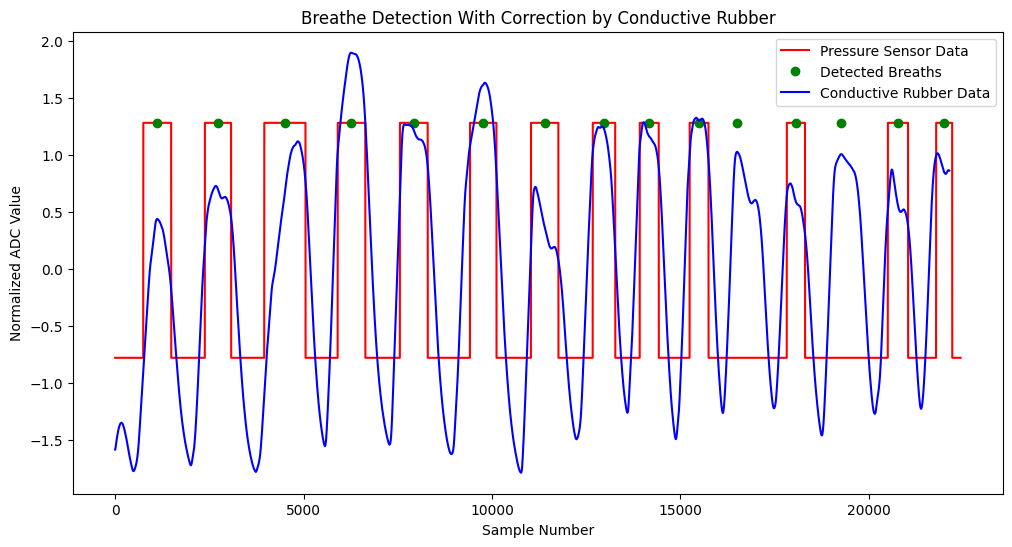

In [1571]:
# plot the final peak index
plt.figure(figsize=(12, 6))
# create of array of length of p_filtered_normalized with max value of p_filtered_normalized
array_peak = np.ones(len(p_filtered_normalized)) * np.max(p_filtered_normalized)
plt.plot(p_filtered_normalized, label='Pressure Sensor Data', color='red')
plt.plot(final_peak_index, array_peak[final_peak_index], 'go', label='Detected Breaths')
plt.plot(c_filtered_normalized, label='Conductive Rubber Data', color='blue')
plt.legend()
plt.title("Breathe Detection With Correction by Conductive Rubber")
plt.xlabel("Sample Number")
plt.ylabel("Normalized ADC Value")

Text(0, 0.5, 'Normalized ADC Value')

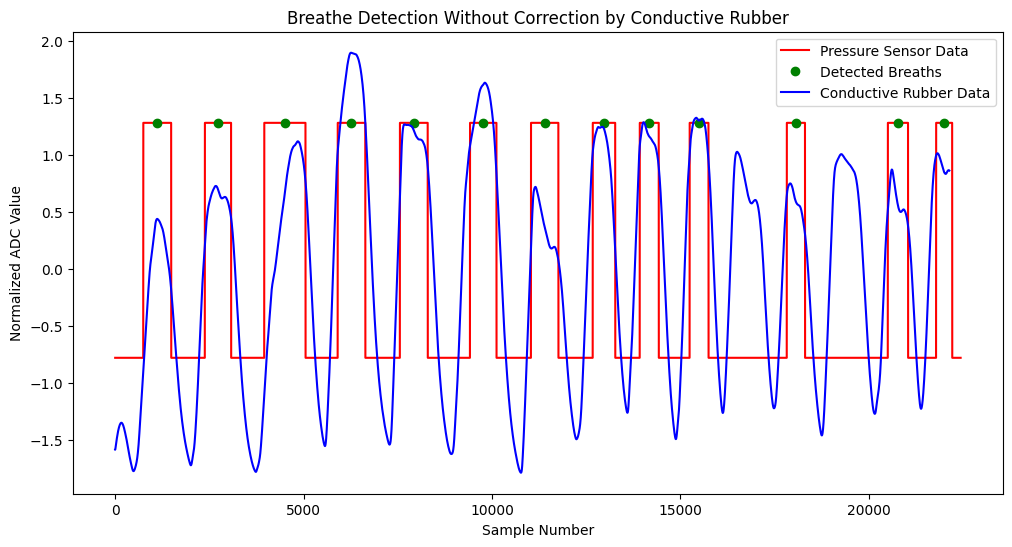

In [1572]:
# plot the final peak index
plt.figure(figsize=(12, 6))
# create of array of length of p_filtered_normalized with max value of p_filtered_normalized
array_peak = np.ones(len(p_filtered_normalized)) * np.max(p_filtered_normalized)
plt.plot(p_filtered_normalized, label='Pressure Sensor Data', color='red')
plt.plot(peak_p, array_peak[peak_p], 'go', label='Detected Breaths')
plt.plot(c_filtered_normalized, label='Conductive Rubber Data', color='blue')
plt.legend()
plt.title("Breathe Detection Without Correction by Conductive Rubber")
plt.xlabel("Sample Number")
plt.ylabel("Normalized ADC Value")